In [20]:
# import necessary libraries
import os
import glob

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout


In [89]:
!ls -fat
!pwd

.                     vectors_Shapes        training_2
..                    PREDICTION            history_all_bands.csv
shape                 datasets
.DS_Store             prediction_Rasters
/Users/jamalmbaye/Dev/Halimatou/CRS OBSERVATOIRE/DeepLearning/datasets/Senegal_DeepLearning


In [2]:
working_dir="/Users/jamalmbaye/Dev/Halimatou/CRS OBSERVATOIRE/DeepLearning/datasets/Senegal_DeepLearning"
os.chdir(working_dir)

In [3]:
!ls -falt


total 16
drwxr-xr-x@  6 jamalmbaye  staff   192 Sep  2 22:59 .
drwxrwxr-x@ 13 jamalmbaye  staff   416 Sep  2 23:14 ..
drwxr-xr-x   8 jamalmbaye  staff   256 Sep  2 21:58 shape
-rw-r--r--@  1 jamalmbaye  staff  6148 Sep  2 23:00 .DS_Store
drwxr-xr-x   8 jamalmbaye  staff   256 Sep  2 22:59 vectors_Shapes
drwxr-xr-x  11 jamalmbaye  staff   352 Sep  3 08:20 datasets


### loadind datasets


In [5]:
xtrain=np.load("datasets/XXtrain_datasets.npy")
ytrain=np.load("datasets/YYtrain_datasets.npy")

xtrain.shape, ytrain.shape , xtrain.min(),xtrain.max()

((154, 256, 256, 8), (154, 256, 256, 1), 0.0, 1.0)

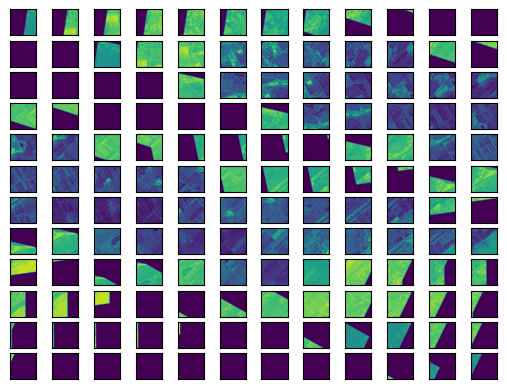

In [6]:
for i in range(144):
    ax=plt.subplot(12,12,1+i)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.imshow(xtrain[i,:,:,1])

plt.show()

Text(0.5, 1.0, 'label data by\ngoogle earth engine ')

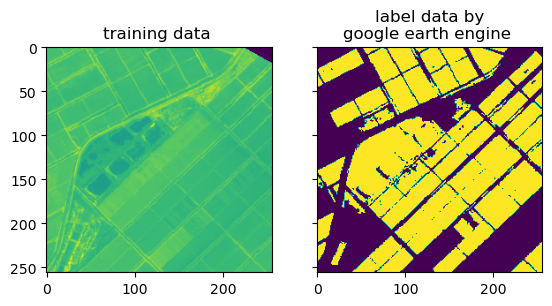

In [91]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(xtrain[100,:,:,1])
ax1.set_title('training data ')
ax2.imshow(ytrain[100,:,:,0])
ax2.set_title('label data by\ngoogle earth engine ')




In [8]:

# Define the input with shape (256, 256, 9)
input_layer = Input(shape=(256, 256, 8))

# Encoder
# 1st Convolutional Block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)  # Conv layer with 32 filters
x = Dropout(0.25)(x)  # Dropout for regularization
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Another Conv layer
x = MaxPooling2D((2, 2))(x_skip1)  # Downsample the feature map

# 2nd Convolutional Block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x_skip2)

# 3rd Convolutional Block
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x_skip3)

# Final Convolutional Block in Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Decoder
# 1st Transposed Convolutional Block
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = Concatenate()([x, x_skip3])  # Skip connection from encoder

# 2nd Transposed Convolutional Block
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = Concatenate()([x, x_skip2])  # Another skip connection

# 3rd Transposed Convolutional Block
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = Concatenate()([x, x_skip1])  # Final skip connection

# Final Transposed Convolutional Block in Decoder
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)

# 1x1 Convolution to get the desired output
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)  # Sigmoid for binary output

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model model.compile(loss='binary_crossentropy', optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics="accuracy")
model.summary()


2024-09-03 12:04:41.899621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## callbacks for saving history and weights

In [15]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cvlogs=tf.keras.callbacks.CSVLogger(
    filename="history.csv", separator=',', append=True
)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Run fit to train the model

In [16]:
history = model.fit(xtrain, ytrain,
                    epochs=100,
                    batch_size=8,
                    callbacks=[cp_callback,cvlogs],
                    verbose=1)

Epoch 1/100
20/20 [==============================] - 16s 761ms/step - loss: 0.0620 - accuracy: 0.9845

Epoch 1: saving model to training_2/cp.ckpt
Epoch 2/100
20/20 [==============================] - 15s 754ms/step - loss: 0.0618 - accuracy: 0.9847

Epoch 2: saving model to training_2/cp.ckpt
Epoch 3/100
20/20 [==============================] - 15s 756ms/step - loss: 0.0595 - accuracy: 0.9851

Epoch 3: saving model to training_2/cp.ckpt
Epoch 4/100
20/20 [==============================] - 15s 767ms/step - loss: 0.0607 - accuracy: 0.9851

Epoch 4: saving model to training_2/cp.ckpt
Epoch 5/100
20/20 [==============================] - 15s 767ms/step - loss: 0.0597 - accuracy: 0.9852

Epoch 5: saving model to training_2/cp.ckpt
Epoch 6/100
20/20 [==============================] - 15s 764ms/step - loss: 0.0596 - accuracy: 0.9852

Epoch 6: saving model to training_2/cp.ckpt
Epoch 7/100
20/20 [==============================] - 15s 761ms/step - loss: 0.0608 - accuracy: 0.9846

Epoch 7: saving

In [21]:
from geotile import GeoTile

In [13]:
model.save_weights("datasets/models_all_bands.h5")

In [24]:
!ls -fal VALIDATION_Reel_DATA_SETS/

total 120472
drwxr-xr-x@ 4 jamalmbaye  staff       128 Sep  3 16:45 .
drwxr-xr-x@ 9 jamalmbaye  staff       288 Sep  3 16:45 ..
-rw-rw-r--@ 1 jamalmbaye  staff  15596009 Sep  3 16:24 S2_Validation.tif
-rw-rw-r--@ 1 jamalmbaye  staff  46080613 Sep  3 16:27 S2_Validation_may.tif


In [73]:
val=GeoTile("VALIDATION_Reel_DATA_SETS/S2jan2024_box.tif")


In [76]:
val.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 4648,
 'height': 3051,
 'count': 8,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -15.887873609523092,
        0.0, -8.983152841195215e-05, 16.54948281627712)}

In [77]:
val.generate_tiles(save_tiles=False, stride_x=256,stride_y=256)
val.convert_nan_to_zero()
val.normalize_tiles()

In [78]:
val.tile_data.shape

(228, 256, 256, 8)

In [79]:
pred_raster=model.predict(val.tile_data)

In [81]:
pred_raster=(pred_raster >0.2).astype(np.uint8)
print(pred_raster.shape)

(228, 256, 256, 1)


In [82]:
val.tile_data=pred_raster

In [83]:
val.save_tiles("prediction_Rasters")

In [84]:
from geotile import mosaic

In [85]:
mosaic("prediction_Rasters/","predicted.tif")

'predicted.tif'